# Moment sensitivity for PSR/DSR/MinTRL

Sweep skewness, kurtosis (excess), and Sharpe benchmarks while holding other moments constant.
Synthetic returns come from a Johnson SU fit that roughly matches the requested skew/kurtosis, then get rescaled to a fixed mean/vol.


In [1]:
from pathlib import Path
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize

# Make local src/ importable whether running from repo root or notebooks/
ROOT_CANDIDATES = [Path.cwd()] + list(Path.cwd().parents)
REPO_ROOT = next((p for p in ROOT_CANDIDATES if (p / "src" / "finance_data").exists()), Path.cwd())
SRC_PATH = REPO_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from finance_data.metrics import (
    probabilistic_sharpe_ratio,
    deflated_sharpe_ratio,
    min_track_record_length,
)

plt.style.use("seaborn-v0_8")
sns.set_context("talk")
warnings.filterwarnings("ignore", category=RuntimeWarning)


Helper utilities:
- Fit a Johnson SU distribution to approximate target skew and excess kurtosis.
- Simulate returns with fixed mean/vol while preserving the shape moments.
- Compute PSR/DSR/MinTRL for a series.
- Sweep a single parameter while freezing the others.


In [2]:
# Johnson SU calibration to hit target skew / excess kurtosis
def johnson_params_for_moments(target_skew: float, target_kurtosis_excess: float, *, skew_weight: float = 3.0, kurt_weight: float = 1.0):
    bounds = [(-10.0, 10.0), (0.05, 10.0)]
    x0 = np.array([target_skew, 1.5])

    def objective(x):
        a, b = x
        with np.errstate(all="ignore"):
            skew, kurt_ex = stats.johnsonsu.stats(a, b, moments="sk")
        if not np.isfinite(skew) or not np.isfinite(kurt_ex):
            return 1e6
        return skew_weight * (skew - target_skew) ** 2 + kurt_weight * (kurt_ex - target_kurtosis_excess) ** 2

    res = minimize(objective, x0=x0, bounds=bounds, options={"maxiter": 400})
    success = bool(res.success) and np.isfinite(res.fun)
    a, b = (float(res.x[0]), float(res.x[1])) if success else (0.0, 1.0)
    return a, b, success


# Draw synthetic returns with requested skew/kurtosis and rescale to mean/vol
def simulate_returns(
    *,
    n_obs: int,
    mean: float,
    vol: float,
    target_skew: float,
    target_kurtosis_excess: float,
    random_state: int | np.random.Generator,
):
    rng = random_state if isinstance(random_state, np.random.Generator) else np.random.default_rng(random_state)
    a, b, ok = johnson_params_for_moments(target_skew, target_kurtosis_excess)
    draws = stats.johnsonsu.rvs(a, b, size=n_obs, random_state=rng)
    draws = (draws - np.mean(draws)) / np.std(draws, ddof=0)
    returns = mean + vol * draws
    sample_skew = stats.skew(returns, bias=False)
    sample_kurtosis = stats.kurtosis(returns, fisher=False, bias=False)
    return pd.Series(returns), {
        "target_skew": target_skew,
        "target_kurtosis_excess": target_kurtosis_excess,
        "sample_skew": sample_skew,
        "sample_kurtosis": sample_kurtosis,
        "sample_kurtosis_excess": sample_kurtosis - 3.0,
        "johnson_a": a,
        "johnson_b": b,
        "params_ok": ok,
    }


def compute_psr_dsr_mintrl(
    r: pd.Series,
    *,
    sr_benchmark: float,
    m_eff: float,
    conf_level: float,
    periods_per_year: int,
):
    psr, sr_hat = probabilistic_sharpe_ratio(r, sr_benchmark=sr_benchmark)
    dsr, sr_hat_dsr, sr0_dsr = deflated_sharpe_ratio(r, m_eff=m_eff)
    mintrl = min_track_record_length(
        r,
        sr_benchmark=sr_benchmark,
        conf_level=conf_level,
        periods_per_year=periods_per_year,
        m_eff=m_eff,
    )
    return {
        "sr_hat": sr_hat,
        "psr": psr,
        "dsr": dsr,
        "sr0_dsr": sr0_dsr,
        "mintrl_obs": mintrl["min_obs"],
        "mintrl_years": mintrl["min_years"],
    }


def sweep_parameter(
    kind: str,
    values,
    *,
    base_mean: float,
    base_vol: float,
    base_skew: float,
    base_kurtosis_excess: float,
    sr_benchmark: float,
    n_obs: int,
    m_eff: float,
    conf_level: float,
    periods_per_year: int,
    rng_seed: int,
    returns_override: pd.Series | None = None,
):
    rng = np.random.default_rng(rng_seed)
    rows = []
    for val in values:
        skew = base_skew
        kurt_ex = base_kurtosis_excess
        sr0 = sr_benchmark
        if kind == "kurtosis_excess":
            kurt_ex = float(val)
        elif kind == "skewness":
            skew = float(val)
        elif kind == "sr_benchmark":
            sr0 = float(val)
        else:
            raise ValueError(f"Unknown sweep kind: {kind}")

        if returns_override is None:
            seed = int(rng.integers(0, 2**32 - 1))
            r, moments = simulate_returns(
                n_obs=n_obs,
                mean=base_mean,
                vol=base_vol,
                target_skew=skew,
                target_kurtosis_excess=kurt_ex,
                random_state=seed,
            )
        else:
            r = returns_override
            moments = {
                "target_skew": skew,
                "target_kurtosis_excess": kurt_ex,
                "sample_skew": stats.skew(r, bias=False),
                "sample_kurtosis": stats.kurtosis(r, fisher=False, bias=False),
                "sample_kurtosis_excess": stats.kurtosis(r, fisher=True, bias=False),
                "johnson_a": np.nan,
                "johnson_b": np.nan,
                "params_ok": True,
            }

        metrics = compute_psr_dsr_mintrl(
            r,
            sr_benchmark=sr0,
            m_eff=m_eff,
            conf_level=conf_level,
            periods_per_year=periods_per_year,
        )
        row = {kind: val, "sr_benchmark_used": sr0}
        row.update(moments)
        row.update(metrics)
        rows.append(row)

    return pd.DataFrame(rows)


def plot_sweep(df: pd.DataFrame, *, x_col: str, title: str):
    fig, ax1 = plt.subplots(figsize=(9, 4))
    ax1.plot(df[x_col], df["psr"], marker="o", label="PSR")
    ax1.plot(df[x_col], df["dsr"], marker="o", label="DSR")
    ax1.set_xlabel(x_col)
    ax1.set_ylabel("Probability")
    ax1.set_ylim(0, 1.05)

    ax2 = ax1.twinx()
    ax2.plot(df[x_col], df["mintrl_years"], color="tab:green", linestyle="--", marker="x", label="MinTRL (years)")
    ax2.set_ylabel("Min track record (years)")

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right")
    fig.suptitle(title)
    fig.tight_layout()
    return fig


Baseline configuration: monthly returns with fixed mean/vol, and a modest multiple-testing penalty for DSR/MinTRL.
- Mean = 1% per month, vol = 4% per month (SR ~0.25).
- 240 observations (~20 years monthly) for stable moment estimates.
- SR benchmark grid runs 0 → 1.5 in 0.1 steps.
- Excess kurtosis targets map to full kurtosis via `kurt_excess + 3`.


In [3]:
N_OBS = 1000
PERIODS_PER_YEAR = 12
BASE_MEAN = 0.01
BASE_VOL = 0.04
BASE_SKEW = 0.0
BASE_KURTOSIS_EXCESS = 5.0
M_EFF = 3
CONF_LEVEL = 0.99
SR_BENCHMARK_BASE = 0.5

# Base sample reused for the SR benchmark sweep
base_returns, base_moments = simulate_returns(
    n_obs=N_OBS,
    mean=BASE_MEAN,
    vol=BASE_VOL,
    target_skew=BASE_SKEW,
    target_kurtosis_excess=BASE_KURTOSIS_EXCESS,
    random_state=123,
)
base_metrics = compute_psr_dsr_mintrl(
    base_returns,
    sr_benchmark=SR_BENCHMARK_BASE,
    m_eff=M_EFF,
    conf_level=CONF_LEVEL,
    periods_per_year=PERIODS_PER_YEAR,
)
print({"base_moments": base_moments, "base_metrics": base_metrics})


{'base_moments': {'target_skew': 0.0, 'target_kurtosis_excess': 5.0, 'sample_skew': np.float64(-0.24332155081993384), 'sample_kurtosis': np.float64(7.562118532035916), 'sample_kurtosis_excess': np.float64(4.562118532035916), 'johnson_a': -1.7846585924176819e-09, 'johnson_b': 1.4081974793387406, 'params_ok': np.True_}, 'base_metrics': {'sr_hat': 0.25, 'psr': 8.423664232906295e-11, 'dsr': 0.999999999953165, 'sr0_dsr': 0.029087553588593537, 'mintrl_obs': inf, 'mintrl_years': inf}}


## Sensitivity: vary kurtosis (excess 0 → 40) holding skew = 0 and SR0 = 0.5
The Johnson SU fit may not hit extreme combinations exactly; sampled skew/kurtosis columns show what was achieved.


In [4]:
kurt_grid = np.linspace(0, 40, 9)
kurt_df = sweep_parameter(
    "kurtosis_excess",
    kurt_grid,
    base_mean=BASE_MEAN,
    base_vol=BASE_VOL,
    base_skew=BASE_SKEW,
    base_kurtosis_excess=BASE_KURTOSIS_EXCESS,
    sr_benchmark=SR_BENCHMARK_BASE,
    n_obs=N_OBS,
    m_eff=M_EFF,
    conf_level=CONF_LEVEL,
    periods_per_year=PERIODS_PER_YEAR,
    rng_seed=2024,
)
kurt_df[["kurtosis_excess", "sample_skew", "sample_kurtosis", "psr", "dsr", "mintrl_years"]]


,kurtosis_excess,sample_skew,sample_kurtosis,psr,dsr,mintrl_years
0,0.0,0.040173,3.075507,3.071566e-14,1.0,inf
1,5.0,0.370903,5.123987,1.133227e-14,1.0,inf
2,10.0,-0.310705,5.930342,3.181040e-11,1.0,inf
3,15.0,-0.361067,8.615508,4.062086e-10,1.0,inf
4,20.0,-0.303145,5.733285,2.495416e-11,1.0,inf
5,25.0,0.046467,9.964458,9.046577e-11,1.0,inf
6,30.0,0.058293,20.229674,4.083735e-08,1.0,inf
7,35.0,1.211192,18.423013,4.260176e-11,1.0,inf
8,40.0,0.392588,10.869777,1.644799e-11,1.0,inf


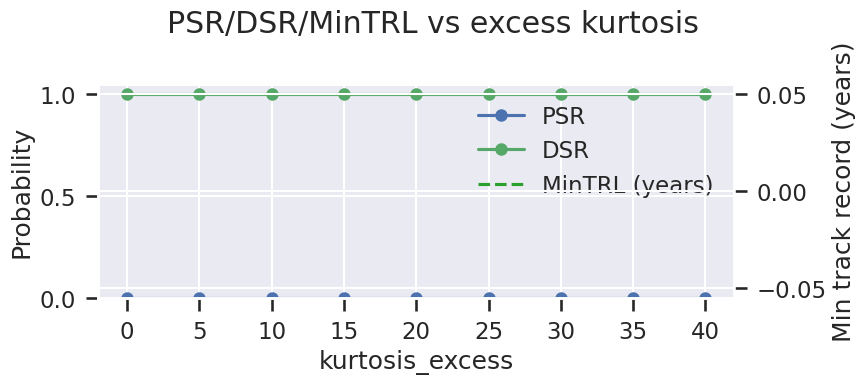

In [5]:
plot_sweep(kurt_df, x_col="kurtosis_excess", title="PSR/DSR/MinTRL vs excess kurtosis");


## Sensitivity: vary skewness (-1 → 1) holding excess kurtosis = 10 and SR0 = 0.5


In [6]:
skew_grid = np.linspace(-1, 1, 9)
skew_df = sweep_parameter(
    "skewness",
    skew_grid,
    base_mean=BASE_MEAN,
    base_vol=BASE_VOL,
    base_skew=BASE_SKEW,
    base_kurtosis_excess=10.0,
    sr_benchmark=SR_BENCHMARK_BASE,
    n_obs=N_OBS,
    m_eff=M_EFF,
    conf_level=CONF_LEVEL,
    periods_per_year=PERIODS_PER_YEAR,
    rng_seed=2025,
)
skew_df[["skewness", "sample_skew", "sample_kurtosis", "psr", "dsr", "mintrl_years"]]


,skewness,sample_skew,sample_kurtosis,psr,dsr,mintrl_years
0,-1.00,0.249683,8.625584,5.241358e-12,1.000000,inf
1,-0.75,-0.503331,7.736273,4.897907e-10,1.000000,inf
2,-0.50,-2.014618,27.809153,1.898347e-05,0.999999,inf
3,-0.25,-0.144334,7.484858,3.910570e-11,1.000000,inf
4,0.00,-0.416442,15.469935,2.676546e-08,1.000000,inf
5,0.25,0.528401,11.445607,9.812872e-12,1.000000,inf
6,0.50,1.243533,15.610889,1.740898e-12,1.000000,inf
7,0.75,1.200371,9.940354,3.383189e-16,1.000000,inf
8,1.00,0.724936,7.604262,6.093280e-15,1.000000,inf


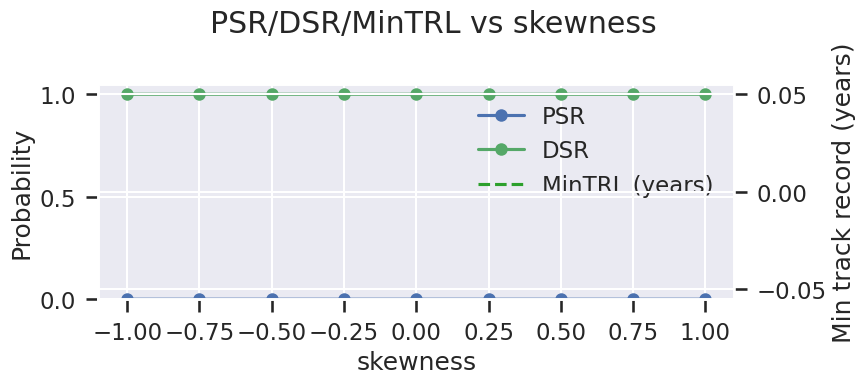

In [7]:
plot_sweep(skew_df, x_col="skewness", title="PSR/DSR/MinTRL vs skewness");


## Sensitivity: vary SR benchmark (0 → 1.5) using a fixed return sample
Reuses the base return path so only the benchmark shifts.


In [8]:
sr_grid = np.round(np.arange(0, 1.5, 0.01), 3)
sr_df = sweep_parameter(
    "sr_benchmark",
    sr_grid,
    base_mean=BASE_MEAN,
    base_vol=BASE_VOL,
    base_skew=BASE_SKEW,
    base_kurtosis_excess=BASE_KURTOSIS_EXCESS,
    sr_benchmark=SR_BENCHMARK_BASE,
    n_obs=N_OBS,
    m_eff=M_EFF,
    conf_level=CONF_LEVEL,
    periods_per_year=PERIODS_PER_YEAR,
    rng_seed=2026,
    returns_override=base_returns,
)
sr_df[["sr_benchmark", "sr_hat", "psr", "dsr", "mintrl_years"]]


,sr_benchmark,sr_hat,psr,dsr,mintrl_years
0,0.00,0.25,1.000000e+00,1.0,9.319418
1,0.01,0.25,1.000000e+00,1.0,10.260100
2,0.02,0.25,1.000000e+00,1.0,11.350215
3,0.03,0.25,1.000000e+00,1.0,12.622472
4,0.04,0.25,1.000000e+00,1.0,14.118965
...,...,...,...,...,...
145,1.45,0.25,1.755371e-67,1.0,inf
146,1.46,0.25,6.883629e-68,1.0,inf
147,1.47,0.25,2.723544e-68,1.0,inf
148,1.48,0.25,1.087129e-68,1.0,inf


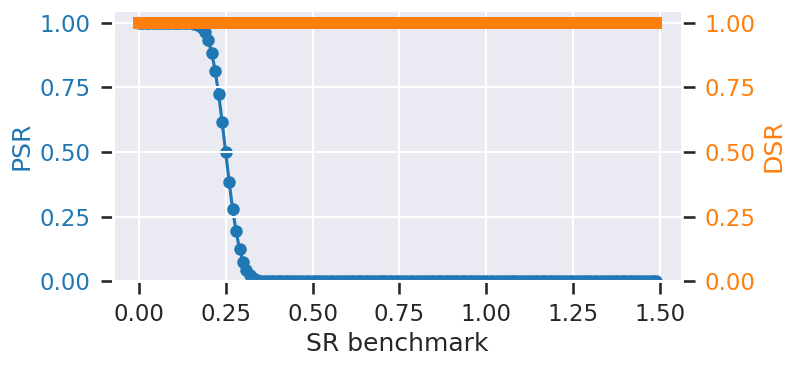

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# PSR on left y-axis
ax1.plot(sr_df["sr_benchmark"], sr_df["psr"], marker="o", label="PSR", color="tab:blue")
ax1.set_xlabel("SR benchmark")
ax1.set_ylabel("PSR", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 1.05)

# DSR on right y-axis
ax2 = ax1.twinx()
ax2.plot(sr_df["sr_benchmark"], sr_df["dsr"], marker="s", label="DSR", color="tab:orange")
ax2.set_ylabel("DSR", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, 1.05)

fig.tight_layout()
plt.show()


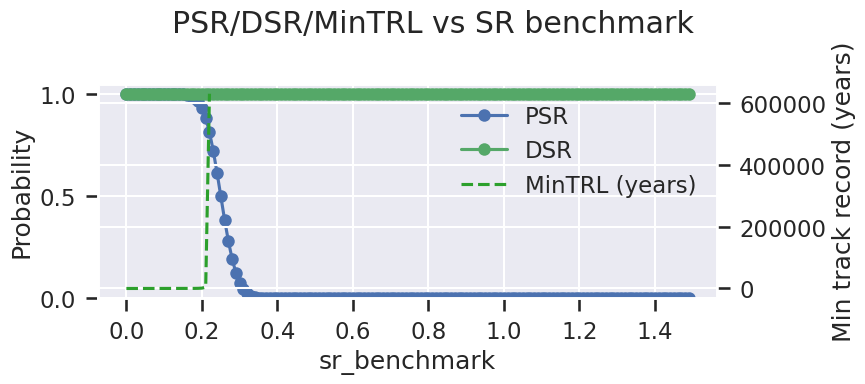

In [10]:
plot_sweep(sr_df, x_col="sr_benchmark", title="PSR/DSR/MinTRL vs SR benchmark");


## Sensitivity: vary observed SR_hat with SR0 = 0 (mean shifts, vol fixed)
Use the same base return path but shift the mean so the realized SR_hat hits a target grid, while keeping volatility/skew/kurtosis shape intact.


In [11]:
sr_hat_targets = np.round(np.arange(0, 1.51, 0.01), 2)
base_std = base_returns.std(ddof=0)
base_centered = base_returns - base_returns.mean()

sr_hat_rows = []
for sr_hat_target in sr_hat_targets:
    desired_mean = sr_hat_target * base_std
    r_adj = base_centered + desired_mean
    metrics = compute_psr_dsr_mintrl(
        r_adj,
        sr_benchmark=0.0,
        m_eff=M_EFF,
        conf_level=CONF_LEVEL,
        periods_per_year=PERIODS_PER_YEAR,
    )
    sr_hat_rows.append(
        {
            "sr_hat_target": sr_hat_target,
            "sr_hat_realized": metrics["sr_hat"],
            "psr": metrics["psr"],
            "dsr": metrics["dsr"],
            "mintrl_years": metrics["mintrl_years"],
        }
    )

sr_hat_df = pd.DataFrame(sr_hat_rows)
sr_hat_df


,sr_hat_target,sr_hat_realized,psr,dsr,mintrl_years
0,0.00,6.938894e-18,0.500000,0.196884,inf
1,0.01,1.000000e-02,0.624085,0.295638,inf
2,0.02,2.000000e-02,0.736455,0.412123,inf
3,0.03,3.000000e-02,0.828609,0.536549,5.353011e+04
4,0.04,4.000000e-02,0.897048,0.657027,2.745813e+03
...,...,...,...,...,...
146,1.46,1.460000e+00,1.000000,1.000000,2.345560e-01
147,1.47,1.470000e+00,1.000000,1.000000,2.313739e-01
148,1.48,1.480000e+00,1.000000,1.000000,2.282568e-01
149,1.49,1.490000e+00,1.000000,1.000000,2.252030e-01


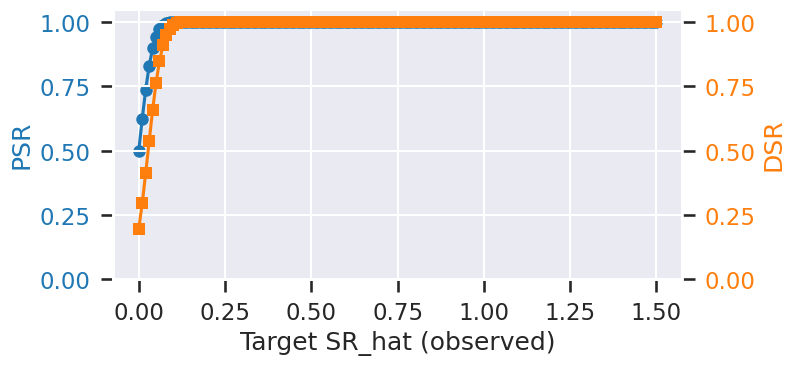

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(sr_hat_df["sr_hat_target"], sr_hat_df["psr"], marker="o", color="tab:blue", label="PSR")
ax1.set_xlabel("Target SR_hat (observed)")
ax1.set_ylabel("PSR", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
ax2.plot(sr_hat_df["sr_hat_target"], sr_hat_df["dsr"], marker="s", color="tab:orange", label="DSR")
ax2.set_ylabel("DSR", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, 1.05)

fig.tight_layout()
plt.show()
